# Testing random number generators

### Setup

First, we want to import both `numpy` and `matplotlib`, but we also want the `numpy` random number generator to be avilable directly in case we want to swap it out for other libraries easily and not have to change any of our downstream code.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng

It is always good to look at the source documentation for information about how the libraries and the functions that they provide are used, as well as useful tidbits and examples. I used the `numpy` source directly for this:

* https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html

Now, let's just print out a few random numbers to make sure we know what we're doing.

In [32]:
num_test_outputs = 10
rng.random(size=num_test_outputs)

array([0.28365406, 0.04244663, 0.83401653, 0.17590071, 0.63940638,
       0.48085389, 0.2255862 , 0.68033538, 0.59390883, 0.47788692])

As with any physics problem, you should take a moment and look at the output here and make sure it passes the sanity checks. 

* Did you get the number of outputs that you expected?
  * Should be equal to `num_test_outputs`
* Do they have values in the range that you expect given the function used?
* Is the format of output object from the function what you expected?

### Basic random number generation and study

We will want to generate a large set of random numbers and begin to analyze their values. One way to do this is to assess the *Cumulative Distribution Function*. A standard definition for this is:

> the probability of observing a value at most some given value `x`

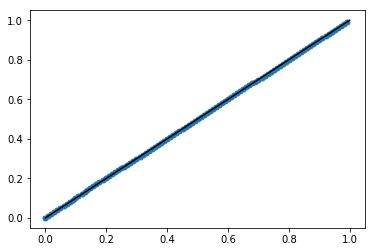

In [33]:
# Specify the number of outputs that we want to work with for this example
num_outputs = 100000

# Generate sorted random numbers
x = np.sort(rng.random(size=num_outputs))   # This returns an array

# Generate y-axis for the cumulative distribution function (CDF)
y = np.arange(1, len(x)+1) / len(x)          # Return evenly spaced values within a given interval.

# Plot CDF from random numbers (for plotting purposes, only plot 100 points)
plt.plot(x[::1000], y[::1000], marker='.', linestyle='none', markersize=10)

# Plot expected CDF (should just a straight line from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], 'k-')

Another way of thinking about this might be to *add* two such random numbers together and make sure that the most probably value is the sum of the average and that it maxes out at the maximum possible value. 

Here, we will actual look at how writing this code in a "C++ way" might differ from a "pythonic" way.

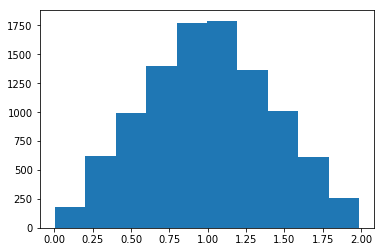

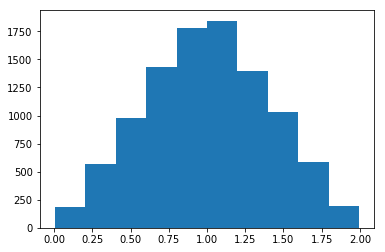

In [36]:
# Specify the number of samples to test
num_samples = 10000

# The C++ way
randomsum = []                             # This is an empty array meant to hold the sequence of sums that we generate
for i in range(num_samples):               # This is our `for` loop, which aside frome some basic syntax, looks just like C++
    total = rng.random() + rng.random()    # Here is where we generate a sum of two random numbers
    randomsum.append(total)                # Now we have to put this sum into our array for later plotting

# We've now finished the `for` loop, so we can start plotting
num_bins = 10                             # This specifies the number of bins that we want in our histogram
plt.hist(randomsum, num_bins)              # This builds the histogram with the values stored in `randomsum` and 
plt.show()                                 # This forces display of the plots

# The python way
newrandomsum = [sum(x) for x in zip(rng.random(num_samples), rng.random(num_samples))]   # It's a long line, but it's one line nonetheless

plt.hist(newrandomsum, num_bins)           # This builds the histogram with the values stored in `randomsum` and 
plt.show()                                 # This forces display of the plots

The only "tricky" thing about the above *pythonic* approach was the use of `zip`

* https://docs.python.org/3/library/functions.html#zip

~~~~
>>> x = [1, 2, 3]
>>> y = [4, 5, 6]
>>> zipped = zip(x, y)
>>> list(zipped)
[(1, 4), (2, 5), (3, 6)]
~~~~

So, the effect is that we obtain an element-by-element pair from the two lists of `num_samples` of random numbers. Then, the use of `sum` merely adds each of those pairs, or *tuples* together, yielding a summed list `num_samples` long.

### Quantitative tests of random number generators

As discussed in lecture, we need to contruct a test of the uniformity of our dataset. One way to do that is to compare against the expectation of an exactly equal rate of population statistics for equal intervals in the range of the random number generator.

First, we need to write a function that computes the chi-squared

In [53]:
# Simple function for computing a chi-squared given a set of input values from a histogram and their expectations
def my_uniform_chisq(bin_values, bin_expectations):
    num_bins = len(bin_values)
    chi_square = sum( ( ((bin_values[i] - bin_expectations[i])**2) / bin_values[i] ) for i in range(num_bins))
    return(chi_square)

[105.  83.  92. 103. 122.  93.  97.  97. 100. 108.]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


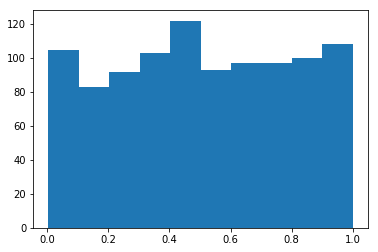

In [95]:
# Now, just as in lecture, populate a histogram that we will then test
samples  = 1000                                         # Number of samples of the RNG
num_bins = 10                                              # Number of bins in the histogram (effectively specifies the interval)
data     = rng.random(samples)                             # Fill a numpy array with random numbers `samples` times
bin_values, bin_edges, patches = plt.hist(data,num_bins)   # Fill the histogram, and save the values of each of the bins

# Always good to check that you know what you're doing 
print(bin_values)                                          # Print out the values of the bins to cross-check the plot 

# Fill an array with the expectations for the bin values
bin_expectations = [samples/num_bins] * num_bins           # This is a trick to initialize an array with a given length (num_bins)

# Again, just to make sure we're on track, print everything out
print(bin_expectations)

Now all we have to do is plug these arrays into our chi-squared calculation!

In [101]:
chisq = my_uniform_chisq(bin_values,bin_expectations)

print(chisq)

9.77530820171443
